In [1]:
import time
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import numpy as np
import random
import joblib

In [3]:
# Load CNN model for feature extraction
cnn_model = load_model(r"C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\cnn_model.h5")
cnn_model = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('flatten').output)

# Freeze layers
for layer in cnn_model.layers:
    layer.trainable = False


In [4]:
# Image directories
train_dir = r"K:\PROJECT\ORGANISED DATASET\train"
test_dir = r"K:\PROJECT\ORGANISED DATASET\test"

# Image preprocessing
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)


In [5]:
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)


Found 6185 images belonging to 2 classes.
Found 1724 images belonging to 2 classes.


In [6]:
# Feature extraction
def extract_features(generator, model):
    features = model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

train_features, train_labels = extract_features(train_generator, cnn_model)
test_features, test_labels = extract_features(test_generator, cnn_model)

54/54 [==============================] - 34s 618ms/step


In [7]:
print(f"Original feature dimensions: {train_features.shape[1]}")
# Feature scaling
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

Original feature dimensions: 86528


In [8]:
def jaya_optimization(train_features, train_labels, test_features, test_labels, max_iter=10, population_size=5):
    """
    Jaya Optimization for PCA components and XGBoost hyperparameters.
    """
    start_time = time.time()

    # Define hyperparameter ranges
    min_components, max_components = 100, 400
    min_n_estimators, max_n_estimators = 50, 300
    min_learning_rate, max_learning_rate = 0.01, 0.3
    min_max_depth, max_max_depth = 3, 10

    # Initialize population
    population = []
    for _ in range(population_size):
        params = {
            'n_components': random.randint(min_components, max_components),
            'n_estimators': random.randint(min_n_estimators, max_n_estimators),
            'learning_rate': random.uniform(min_learning_rate, max_learning_rate),
            'max_depth': random.randint(min_max_depth, max_max_depth),
        }
        population.append(params)

    # Evaluate initial population
    def evaluate(params):
        pca = PCA(n_components=params['n_components'])
        train_pca = pca.fit_transform(train_features)
        test_pca = pca.transform(test_features)

        xgb = XGBClassifier(n_estimators=params['n_estimators'],
                            learning_rate=params['learning_rate'],
                            max_depth=params['max_depth'],
                            use_label_encoder=False, eval_metric='logloss')
        xgb.fit(train_pca, train_labels)
        predictions = xgb.predict(test_pca)
        return accuracy_score(test_labels, predictions)

    best_params = None
    best_accuracy = 0

    for iteration in range(max_iter):
        iter_start = time.time()
        new_population = []

        for params in population:
            # Generate new candidates
            new_params = {
                'n_components': random.randint(min_components, max_components),
                'n_estimators': random.randint(min_n_estimators, max_n_estimators),
                'learning_rate': random.uniform(min_learning_rate, max_learning_rate),
                'max_depth': random.randint(min_max_depth, max_max_depth),
            }

            # Evaluate both old and new candidates
            old_acc = evaluate(params)
            new_acc = evaluate(new_params)

            # Select the better one
            if new_acc > old_acc:
                new_population.append(new_params)
            else:
                new_population.append(params)

            # Update the best accuracy
            if new_acc > best_accuracy:
                best_accuracy = new_acc
                best_params = new_params

        population = new_population
        iter_end = time.time()
        iter_time = iter_end - iter_start
        print(f"Iteration {iteration + 1}/{max_iter}, Time: {iter_time:.2f}s, Best Accuracy: {best_accuracy:.4f}")

    total_time = time.time() - start_time
    print(f"Total Jaya Optimization Time: {total_time:.2f} seconds")
    return best_params


In [9]:
# Run Jaya Optimization
best_params = jaya_optimization(train_features_scaled, train_labels, test_features_scaled, test_labels)


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:19:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:20:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:20:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda

Iteration 1/10, Time: 687.23s, Best Accuracy: 0.8730


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:33:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:37:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:39:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda

Iteration 2/10, Time: 1818.92s, Best Accuracy: 0.8730


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:02:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:03:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:04:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda

Iteration 3/10, Time: 509.38s, Best Accuracy: 0.8730


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:09:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:10:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:11:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda

Iteration 4/10, Time: 378.99s, Best Accuracy: 0.8730


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:16:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:17:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:17:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda

Iteration 5/10, Time: 389.98s, Best Accuracy: 0.8730


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:22:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:23:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:24:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda

Iteration 6/10, Time: 505.69s, Best Accuracy: 0.8730


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:31:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:32:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda

Iteration 7/10, Time: 399.60s, Best Accuracy: 0.8730


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:37:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:39:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda

Iteration 8/10, Time: 518.97s, Best Accuracy: 0.8730


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:46:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:46:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:47:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda

Iteration 9/10, Time: 451.41s, Best Accuracy: 0.8730


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:53:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:54:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\K M SASTRY\anaconda

Iteration 10/10, Time: 520.33s, Best Accuracy: 0.8730
Total Jaya Optimization Time: 6180.49 seconds


In [10]:
# Apply best PCA
pca = PCA(n_components=best_params['n_components'])
train_features_pca = pca.fit_transform(train_features_scaled)
test_features_pca = pca.transform(test_features_scaled)
print(f"Optimized PCA components: {best_params['n_components']}")
print(f"Feature count before PCA: {train_features.shape[1]}")
print(f"Feature count after PCA: {train_features_pca.shape[1]}")

Optimized PCA components: 344
Feature count before PCA: 86528
Feature count after PCA: 344


In [11]:
# Train optimized XGBoost
xgb_classifier = XGBClassifier(n_estimators=best_params['n_estimators'],
                               learning_rate=best_params['learning_rate'],
                               max_depth=best_params['max_depth'],
                               use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(train_features_pca, train_labels)

C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.06115806250930469, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=95, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [12]:
# Predict and evaluate
test_predictions = xgb_classifier.predict(test_features_pca)
accuracy = accuracy_score(test_labels, test_predictions)

print(f"Optimized Test Accuracy: {accuracy:.4f}")

Optimized Test Accuracy: 0.8718


In [13]:
from sklearn.metrics import classification_report
import cv2
import os

# Generate Classification Report
report = classification_report(test_labels, test_predictions, target_names=['Benign', 'Malignant'])
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

      Benign       0.84      0.73      0.78       542
   Malignant       0.88      0.94      0.91      1182

    accuracy                           0.87      1724
   macro avg       0.86      0.83      0.85      1724
weighted avg       0.87      0.87      0.87      1724



In [14]:
# Save models
joblib.dump(xgb_classifier, r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\xgb_optimized.pkl")
joblib.dump(pca, r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\pca_optimized.pkl")
joblib.dump(scaler, r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\scaler.pkl")

print("Optimized XGBoost, PCA, and Scaler models saved successfully!")

Optimized XGBoost, PCA, and Scaler models saved successfully!


1/1 [==============================] - 0s 99ms/step


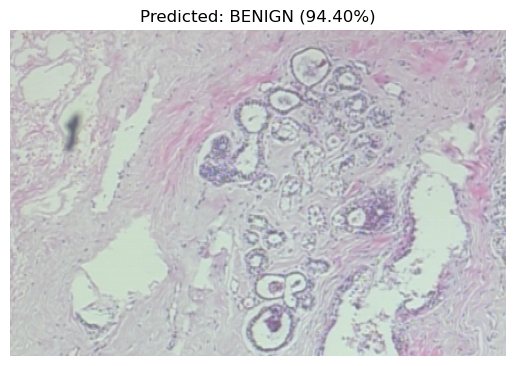

Predicted Class: BENIGN (94.40%)
Class BENIGN: 94.40%
Class MALIGNANT: 5.60%


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import joblib
from tensorflow.keras.models import load_model

# Load trained models
cnn_model = load_model(r"C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\cnn_model.h5")
cnn_model = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('flatten').output)

scaler = joblib.load(r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\scaler.pkl")
pca = joblib.load(r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\pca_optimized.pkl")
xgb_classifier = joblib.load(r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\xgb_optimized.pkl")

# Class labels
class_labels = list(train_generator.class_indices.keys())

# Predict Single Image
def predict_single_image(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Extract features using CNN
    extracted_features = cnn_model.predict(img_array)
    extracted_features_scaled = scaler.transform(extracted_features)
    extracted_features_pca = pca.transform(extracted_features_scaled)

    # Predict using XGBoost
    probabilities = xgb_classifier.predict_proba(extracted_features_pca)[0]
    predicted_class = np.argmax(probabilities)
    predicted_label = class_labels[predicted_class]
    confidence = probabilities[predicted_class] * 100

    # Display the image
    plt.imshow(image.load_img(image_path))
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label} ({confidence:.2f}%)")
    plt.show()

    # Print results
    print(f"Predicted Class: {predicted_label} ({confidence:.2f}%)")
    for i, prob in enumerate(probabilities):
        print(f"Class {class_labels[i]}: {prob * 100:.2f}%")

# Example usage (Replace with actual image path)
image_path = r"K:\PROJECT\ORGANISED DATASET\test\BENIGN\adenosis\SOB_B_A_14-22549AB\40X\SOB_B_A-14-22549AB-40-001.png"
predict_single_image(image_path)


1/1 [==============================] - 0s 82ms/step


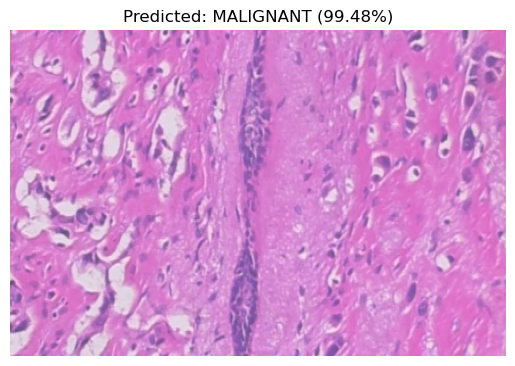

Predicted Class: MALIGNANT (99.48%)
Class BENIGN: 0.52%
Class MALIGNANT: 99.48%


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import joblib
from tensorflow.keras.models import load_model

# Load trained models
cnn_model = load_model(r"C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\cnn_model.h5")
cnn_model = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('flatten').output)

scaler = joblib.load(r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\scaler.pkl")
pca = joblib.load(r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\pca_optimized.pkl")
xgb_classifier = joblib.load(r"C:\Users\K M SASTRY\Desktop\FINAL YEAR PROJECT\xgb_optimized.pkl")

# Class labels
class_labels = list(train_generator.class_indices.keys())

# Predict Single Image
def predict_single_image(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Extract features using CNN
    extracted_features = cnn_model.predict(img_array)
    extracted_features_scaled = scaler.transform(extracted_features)
    extracted_features_pca = pca.transform(extracted_features_scaled)

    # Predict using XGBoost
    probabilities = xgb_classifier.predict_proba(extracted_features_pca)[0]
    predicted_class = np.argmax(probabilities)
    predicted_label = class_labels[predicted_class]
    confidence = probabilities[predicted_class] * 100

    # Display the image
    plt.imshow(image.load_img(image_path))
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label} ({confidence:.2f}%)")
    plt.show()

    # Print results
    print(f"Predicted Class: {predicted_label} ({confidence:.2f}%)")
    for i, prob in enumerate(probabilities):
        print(f"Class {class_labels[i]}: {prob * 100:.2f}%")

# Example usage (Replace with actual image path)
image_path = r"K:\PROJECT\ORGANISED DATASET\test\MALIGNANT\lobular_carcinoma\SOB_M_LC_14-15570\100X\SOB_M_LC-14-15570-100-046.png"
predict_single_image(image_path)
